In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [3]:
import os
swissprot_dir = '/gpfs/alpine/bie108/proj-shared/swissprot/'

swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))
cafa3_targets = pd.read_csv('cafa3/cafa3_annotated_targets_with_swissprot.csv.gz')

In [4]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

In [5]:
swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated = swissprot_annotated[swissprot_annotated.length < 2048]

In [6]:
uniref50_clusters = swissprot_annotated['UniRef50 ID'].unique()
uniref50_nocafa3 = np.array(list(set(uniref50_clusters) - set(cafa3_targets['UniRef50 ID'].unique())))

print(len(uniref50_nocafa3))
np.random.seed(1)
np.random.shuffle(uniref50_nocafa3)
test, valid, train = np.split(uniref50_nocafa3, [3000, 6000])

169738


In [7]:
len(train)

163738

In [8]:
swissprot_train = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(train)].sample(frac=1., random_state=1)
swissprot_valid = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(valid)].sample(frac=1., random_state=1)

In [9]:
len(swissprot_train)

505360

In [10]:
len(swissprot_train) // (6 * 24)

3509

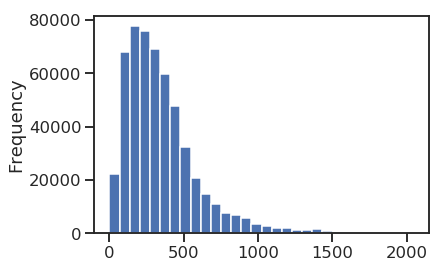

In [11]:
swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [12]:
go_terms.head()

,GENE PRODUCT DB,GENE PRODUCT ID,SYMBOL,QUALIFIER,GO TERM,GO ASPECT,ECO ID,GO EVIDENCE CODE,REFERENCE,WITH/FROM,TAXON ID,ASSIGNED BY,ANNOTATION EXTENSION,DATE
0,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571|InterPro:IPR018354,8613,InterPro,None,20200613
1,UniProtKB,A2CKF6,A2CKF6,involved_in,GO:0009405,P,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571,8613,InterPro,None,20200613
2,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0964,8613,UniProt,None,20200613
3,UniProtKB,A2CKF6,A2CKF6,enables,GO:0090729,F,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0800,8613,UniProt,None,20200613
4,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0035792,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0629,8613,UniProt,None,20200613


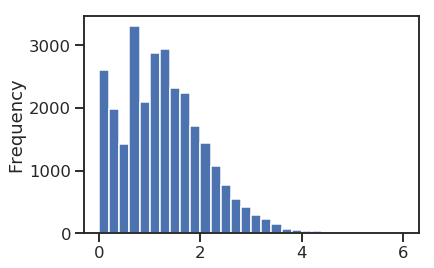

In [13]:
np.log10(go_terms['GO TERM'].value_counts()).plot.hist(range=(0, 6), bins=30)

In [14]:
go_terms_train = go_terms[go_terms['GENE PRODUCT ID'].isin(swissprot_train.accession)]

In [15]:
import sys
sys.path.append('..')

In [16]:
from bert.dataset import encode
from bert.go import Ontology
from tqdm import tqdm
tqdm.pandas()

ont = Ontology(restrict_terms=False)
ont.total_nodes

44232

This line gets the total list of terms present in the training database, including ancestors. Any term that doesn't appear here won't be predicted, so we'll remove it from the ontology tree.

In [17]:
# all_terms = go_terms_train.groupby('GENE PRODUCT ID').progress_apply(lambda df: pd.Series(list(ont.get_ancestors(df['GO TERM'].values))))
# training_terms = all_terms.reset_index()[0].value_counts().index
# pd.Series(training_terms).to_csv('../bert/go/terms.csv.gz', compression='gzip', index=False, header=False)

In [18]:
ont = Ontology()
ont.total_nodes

32012

In [21]:
grouped_go_terms = go_terms.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)
# row = swissprot_annotated.iloc[0]
# ont.termlist_to_array(ont.get_ancestors(grouped_go_terms[row.accession]), dtype=int).shape

In [6]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _serialize_array(value):
    return _bytes_feature(tf.io.serialize_tensor(value))

def inputs_generator(swissprot_df):
    for _, row in tqdm(swissprot_df.iterrows(), total=len(swissprot_df)):
#        sequence = encode(row.sequence, max_seq_len)
        ancestor_array = ont.termlist_to_array(ont.get_ancestors(
            grouped_go_terms[row.accession]), dtype=int)
        
        features = {
            'sequence': _bytes_feature(row.sequence.encode('utf8')),
            'annotation': _serialize_array(ancestor_array)
        }
        
        example_proto = tf.train.Example(features=tf.train.Features(feature=features))
        yield example_proto.SerializeToString()

In [21]:
# example = next(inputs_generator(swissprot_annotated))

# parsed = tf.io.parse_single_example(example, features={
#         'sequence': tf.io.FixedLenFeature([], tf.string, default_value=''),
#         'annotation': tf.io.FixedLenFeature([], tf.string, default_value=''),
#     })

# tf.io.parse_tensor(parsed['annotation'], out_type=tf.int64)

In [22]:
np.savez_compressed('uniref50_split.npz', train=train, valid=valid, test=test)
pd.Series(ont.term_index).to_csv('term_index.csv', header=False)

In [23]:
# Preprocess and write the train dataset to disk
serialized_train_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_train),
    output_types=tf.string, output_shapes=())

filename = os.path.join(swissprot_dir, 'tfrecords_1', 'go_train.tfrecord.gz')
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_train_dataset)


# Preprocess and write the valid dataset to disk
serialized_valid_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_valid),
    output_types=tf.string, output_shapes=())

filename = os.path.join(swissprot_dir, 'tfrecords_1', 'go_valid.tfrecord.gz')
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_valid_dataset)

100%|██████████| 8841/8841 [00:38<00:00, 231.98it/s]


In [7]:
cafa3_accessions = np.load('cafa3/cafa3_accessions.npz', allow_pickle=True)

In [9]:
cafa3_accessions['train']

array(['A0A060X6Z0', 'A0A068FIK2', 'A0A075F932', ..., 'W8E7I1', 'X1WGX5',
       'X5M5N0'], dtype=object)

In [10]:
swissprot_cafa3_train = swissprot_annotated[swissprot_annotated['accession'].isin(cafa3_accessions['train'])].sample(frac=1., random_state=1)
swissprot_cafa3_test = swissprot_annotated[swissprot_annotated['accession'].isin(cafa3_accessions['test'])].sample(frac=1., random_state=1)

In [26]:
swissprot_cafa3_train.shape

(65539, 13)

In [19]:
swissprot_cafa3_test.shape

(3098, 13)

In [25]:
swissprot_cafa3_train.length.max()

2047

In [24]:
swissprot_cafa3_train.shape[0] / (500 * 6 * 16)

1.3653958333333334

In [22]:
# Preprocess and write the train dataset to disk
serialized_cafa3_train_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_cafa3_train),
    output_types=tf.string, output_shapes=())

filename = os.path.join(swissprot_dir, 'tfrecords_1', 'cafa3_train.tfrecord.gz')
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_cafa3_train_dataset)

100%|██████████| 65539/65539 [13:41<00:00, 79.79it/s] 
